In [1]:
%matplotlib widget

import matplotlib
matplotlib.get_backend()


'module://ipympl.backend_nbagg'

HTML(value='<b>Backend:</b> module://ipympl.backend_nbagg')

IntSlider(value=0, description='Scrub', layout=Layout(width='99%'))

Output()

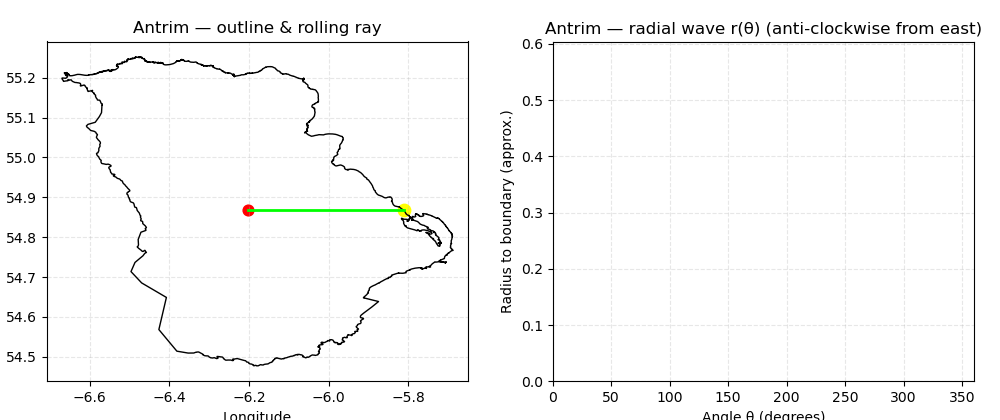

In [5]:
import json, math, time, asyncio
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio
import matplotlib

GEOJSON_PATH = "irish_counties.geojson"   # change if needed

# ---------- geometry helpers ----------
def _name(feat):
    p = feat.get("properties", {})
    for k in ("name_en","NAME","Name","name","COUNTY","County","county"):
        v = p.get(k)
        if isinstance(v, str) and v.strip():
            return v.strip()
    return str(p or feat.get("id") or "Unknown")

def _rings(g):
    t = g.get("type"); C = g.get("coordinates", [])
    conv = lambda r: [(float(x), float(y)) for x,y in r]
    out=[]
    if t=="Polygon":
        for r in C: out.append(conv(r))
    elif t=="MultiPolygon":
        for poly in C:
            for r in poly: out.append(conv(r))
    return out

def _signed_area(r):
    return 0.5*sum(x1*y2-x2*y1 for (x1,y1),(x2,y2) in zip(r, r[1:]))

def _ensure_ccw(r):
    r = r if r[0]==r[-1] else r+[r[0]]
    return r if _signed_area(r)>0 else r[::-1]

def _length(r):
    return sum(math.hypot(x2-x1,y2-y1) for (x1,y1),(x2,y2) in zip(r, r[1:]))

def _centroid(r):
    pts=r[:-1]; A=Cx=Cy=0.0
    for (x1,y1),(x2,y2) in zip(pts, pts[1:]+pts[:1]):
        cr=x1*y2-x2*y1; A+=cr; Cx+=(x1+x2)*cr; Cy+=(y1+y2)*cr
    A*=0.5
    if abs(A)<1e-12:
        xs,ys=zip(*pts); return sum(xs)/len(xs), sum(ys)/len(ys)
    return Cx/(6*A), Cy/(6*A)

def _seg_horiz_intersection(p1,p2,y):
    (x1,y1),(x2,y2)=p1,p2
    if y<min(y1,y2) or y>max(y1,y2): return None
    dy=y2-y1
    if abs(dy)<1e-12: return None
    t=(y-y1)/dy
    if t<0 or t>1: return None
    return (x1+t*(x2-x1), y)

def _start_east(r, c):
    cx,cy=c
    cand=[]
    for i in range(len(r)-1):
        hit=_seg_horiz_intersection(r[i], r[i+1], cy)
        if hit is not None and hit[0]>=cx-1e-12:
            cand.append((i,hit))
    if not cand:
        idx=max(range(len(r)-1), key=lambda k: r[k][0])
        start=r[idx]; pts=r[:-1]
        new=[start]+pts[idx+1:]+pts[:idx]+[start]
        return new, start
    i_edge, start = sorted(cand, key=lambda t:(t[1][0]-cx))[0]
    pts=r[:-1]
    new=pts[:i_edge+1]+[start]+pts[i_edge+1:]
    new=new[i_edge+1:]+new[:i_edge+1]
    new.append(new[0])
    return new, start

def _radial_arrays(closed_points, c):
    pts = closed_points[:-1]; cx,cy=c
    theta=[math.atan2(y-cy,x-cx) for x,y in pts]
    uw=[theta[0]]
    for t in theta[1:]:
        prev=uw[-1]; dt=t-prev
        while dt<=-math.pi: dt+=2*math.pi
        while dt> math.pi:  dt-=2*math.pi
        uw.append(prev+dt)
    shift=uw[0]; uw=[t-shift for t in uw]
    r=[math.hypot(x-cx,y-cy) for x,y in pts]
    return np.array(uw), np.array(r), np.array(pts)

# ---------- load data ----------
with open(GEOJSON_PATH,"r",encoding="utf-8") as f:
    data=json.load(f)
features=data["features"]
name_to_feat={_name(f):f for f in features}
county_names=sorted(name_to_feat.keys())

# ---------- widgets ----------
dd = widgets.Dropdown(
    options=county_names,
    description="County:",
    layout=widgets.Layout(width="26%")
)

play = widgets.Play(
    value=0,
    min=0,
    max=100,
    step=25,
    interval=1,
    description="▶︎",
    disabled=False
)

step = widgets.IntSlider(
    description="Step",
    value=25,
    min=1,
    max=50,
    step=5,
    layout=widgets.Layout(width="20%")
)

speed = widgets.IntSlider(
    description="Interval (ms)",
    value=1,
    min=1,
    max=5,
    step=1,
    layout=widgets.Layout(width="20%")
)

reset = widgets.Button(description="Reset")

btn_sound = widgets.Button(description="Hear wave")
duration_slider = widgets.FloatSlider(
    description="Duration (s)",
    value=4.0,
    min=1.0,
    max=10.0,
    step=0.5,
    readout_format=".1f",
    layout=widgets.Layout(width="30%")
)
key_dropdown = widgets.Dropdown(
    description="Key",
    options=[
        ("A3 (220 Hz)", 220.0),
        ("C4 (261 Hz)", 261.63),
        ("D4 (294 Hz)", 293.66),
        ("E4 (329 Hz)", 329.63),
        ("G4 (392 Hz)", 392.0),
        ("A4 (440 Hz)", 440.0),
    ],
    value=220.0,
    layout=widgets.Layout(width="30%")
)

scrub = widgets.IntSlider(
    description="Scrub",
    value=0,
    min=0,
    max=100,
    step=1,
    continuous_update=True,
    layout=widgets.Layout(width="99%")
)

status = widgets.HTML(value=f"<b>Backend:</b> {matplotlib.get_backend()}")

widgets.jslink((play, 'value'), (scrub, 'value'))
display(
    widgets.HBox([dd, play, step, speed, reset, btn_sound]),
    widgets.HBox([duration_slider, key_dropdown]),
    status,
    scrub,
)

audio_out = widgets.Output()
display(audio_out)

# ---------- figure (slightly smaller) ----------
fig, (axL, axR) = plt.subplots(1, 2, figsize=(10, 4.2))
plt.tight_layout(w_pad=3, rect=(0, 0, 1, 0.95))

line_tr, = axL.plot([], [], linewidth=2.0, color='green')     # tracing line
ray,     = axL.plot([], [], linewidth=2.0, color='lime')      # centroid->point ray
wave,    = axR.plot([], [], linewidth=1.0, color='green')     # wave
centroid_dot = axL.scatter([], [], s=60, color='red')
start_dot    = axL.scatter([], [], s=80, color='yellow')

vline = axR.axvline(0, color='red', linestyle='--', alpha=0.8)
vline.set_visible(False)

STATE={"pts":None,"theta_deg":None,"r":None,"c":None,"N":0,"name":None}
AUDIO={"task":None}

def prepare(name):
    f = name_to_feat[name]
    ring = _ensure_ccw(max(_rings(f["geometry"]), key=_length))
    c = _centroid(ring)
    ring2, start = _start_east(ring, c)
    theta, r, pts = _radial_arrays(ring2, c)
    theta_deg = np.degrees(theta)

    # Left: outline
    axL.clear()
    X=[p[0] for p in ring2]; Y=[p[1] for p in ring2]
    axL.plot(X, Y, linewidth=1.0, color='black')
    axL.set_aspect("equal", adjustable="datalim")
    axL.set_title(f"{name} — outline & rolling ray")
    axL.set_xlabel("Longitude"); axL.set_ylabel("Latitude")
    axL.grid(True, linestyle="--", alpha=0.3)

    global line_tr, ray, centroid_dot, start_dot, vline, wave
    (line_tr,) = axL.plot([], [], linewidth=2.0, color='green')
    (ray,)     = axL.plot([c[0], start[0]], [c[1], start[1]], linewidth=2.0, color='lime')
    centroid_dot = axL.scatter([c[0]],[c[1]], s=60, color='red')
    start_dot    = axL.scatter([start[0]],[start[1]], s=80, color='yellow')

    # Right: wave
    axR.clear()
    axR.set_title(f"{name} — radial wave r(θ) (anti-clockwise from east)")
    axR.set_xlabel("Angle θ (degrees)")
    axR.set_ylabel("Radius to boundary (approx.)")
    axR.grid(True, linestyle="--", alpha=0.3)
    axR.set_xlim(0, max(360, theta_deg.max()))
    axR.set_ylim(0, r.max()*1.05)
    (wave_line,) = axR.plot([], [], linewidth=1.0, color='green')
    wave = wave_line

    vline = axR.axvline(0, color='red', linestyle='--', alpha=0.8)
    vline.set_visible(False)

    scrub.min = 0; scrub.max = len(pts)-1; scrub.value = 0
    play.min  = 0; play.max  = len(pts)-1; play.value = 0
    play.step = step.value; play.interval = speed.value

    STATE.update({"pts":pts,"theta_deg":theta_deg,"r":r,"c":c,"N":len(pts),"name":name})
    fig.canvas.draw_idle()

def update_from_index(i):
    if STATE["pts"] is None: return
    i = int(np.clip(i, 0, STATE["N"]-1))
    pts = STATE["pts"]; c = STATE["c"]
    xs = pts[:i+1,0]; ys = pts[:i+1,1]
    line_tr.set_data(xs, ys)
    ray.set_data([c[0], pts[i,0]], [c[1], pts[i,1]])
    wave.set_data(STATE["theta_deg"][:i+1], STATE["r"][:i+1])
    fig.canvas.draw_idle()
    if "widget" not in matplotlib.get_backend().lower():
        plt.pause(0.001)

# ---------- audio synthesis ----------
def make_audio_from_wave(theta_deg, r, duration, base_freq, sr=44100):
    # Map radius to one octave: [base, 2*base]
    f_min = base_freq
    f_max = base_freq * 2.0

    r_norm = (r - r.min()) / (r.max() - r.min() + 1e-9)
    freqs_wave = f_min + r_norm * (f_max - f_min)

    N = int(duration * sr)
    pos_wave = np.linspace(0, 1, len(freqs_wave))
    pos_t = np.linspace(0, 1, N)
    freqs = np.interp(pos_t, pos_wave, freqs_wave)

    phase = np.cumsum(2 * np.pi * freqs / sr)
    audio = np.sin(phase).astype(np.float32)
    return audio, sr, duration

async def animate_vline(duration):
    vline.set_visible(True)
    fig.canvas.draw_idle()
    t0 = time.perf_counter()
    max_theta = STATE["theta_deg"].max()
    while True:
        t = time.perf_counter() - t0
        if t > duration:
            break
        frac = t / duration
        x = frac * max_theta
        vline.set_xdata([x, x])
        fig.canvas.draw_idle()
        await asyncio.sleep(0.01)
    vline.set_visible(False)
    fig.canvas.draw_idle()

def on_sound_clicked(_):
    if STATE["r"] is None:
        return
    duration = float(duration_slider.value)
    base_freq = float(key_dropdown.value)
    audio, sr, dur = make_audio_from_wave(STATE["theta_deg"], STATE["r"], duration, base_freq)
    with audio_out:
        clear_output(wait=True)
        display(Audio(audio, rate=sr, autoplay=True))
    if AUDIO["task"] is not None and not AUDIO["task"].done():
        AUDIO["task"].cancel()
    AUDIO["task"] = asyncio.create_task(animate_vline(dur))

# ---- wiring ----
def _on_scrub(change):
    if change["name"]=="value":
        update_from_index(change["new"])

def _on_play(change):
    if change["name"]=="value":
        scrub.value = change["new"]
        update_from_index(change["new"])

def _on_step(change):
    if change["name"]=="value":
        play.step = int(change["new"])

def _on_speed(change):
    if change["name"]=="value":
        play.interval = int(change["new"])

def _on_county(change):
    if change["name"]=="value":
        prepare(change["new"])

def _on_reset(_):
    play.value = 0
    update_from_index(0)

scrub.observe(_on_scrub, names="value")
play.observe(_on_play, names="value")
step.observe(_on_step, names="value")
speed.observe(_on_speed, names="value")
dd.observe(_on_county, names="value")
reset.on_click(_on_reset)
btn_sound.on_click(on_sound_clicked)

# init
prepare(dd.value)
update_from_index(0)


In [ ]:
matplotlib.get_backend()